# **Proyecto Final: Aproximación de Figuras a través de Estrategias Evolutivas**

### **Autor: Diego Maldonado Castro**

### **Asignatuta: Computación Evolutiva**

---

## **Introducción**


La compresión de modelos 3D y el reconocimiento de formas es un desafío común en áreas como la visualización científica y el modelado 3D. Una aproximación compacta y precisa de una figura puede reducir significativamente los costos de almacenamiento y procesamiento, manteniendo al mismo tiempo cierta fidelidad geométrica del objeto original.

En este proyecto se aborda este problema mediante la generación de un conjunto de puntos cuya envolvente convexa se asemeje lo más posible a una figura tridimensional objetivo. El objetivo es lograr un equilibrio entre la precisión de la aproximación y la cantidad mínima de información requerida para describirla.

Para alcanzar esta meta, se implementa un algoritmo evolutivo del tipo (𝜇+𝜆). Este enfoque permite explorar de manera eficiente el espacio de soluciones mediante la selección de 𝜇 individuos como padres y la generación de  𝜆 descendientes a través de operadores de cruza y mutación. La métrica utilizada para evaluar cada solución es la Intersection over Union (IoU) en 3D, que cuantifica la similitud entre la envolvente convexa de los puntos generados y la figura objetivo.



## **Marco Teórico**

### **Convex Hull**

#### **Definición**

La envolvente convexa (Convex Hull) de un conjunto de puntos en un espacio euclidiano es el polígono convexo más pequeño que contiene todos los puntos. En 3D, se convierte en un un poliedro que encapsula los puntos.

#### **Propiedades Matemáticas**
- Convexidad: Dados dos puntos dentro del Convex Hull, el segmento que los une también está dentro.
- Minimalidad: Es el menor conjunto convexo que contiene todos los puntos.

### **IoU**

El IoU 3D es una métrica que mide la superposición entre dos volúmenes. En este caso se define como:

$ \text{IoU} = \frac{ \text{Volume}(\text{ConvexHull}(A) \cap \text{ConvexHull}(B)) }{ \text{Volume}(\text{ConvexHull}(A) \cup \text{ConvexHull}(B)) }$

## **Metodología**


In [ ]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from scipy.spatial import ConvexHull
import time

#### **Creación de puntos**
Creamos una cantidad $ n $ de puntos de 3 dimensiones en el rango $[inf,sup]$.

In [3]:
def create_points(inf, sup,n):
    return np.random.uniform(low=inf, high=sup, size=(n, 3))

#### **Convex Hull de puntos**

El Convex Hull genera automáticamente una malla poligonal (caras, aristas y vértices) a partir de un conjunto desorganizado de puntos en 3D. Esto permite:


- Definir una superficie cerrada a partir de puntos dispersos.
- Evitar reconstrucciones manuales de caras (lo que sería inviable para grandes nubes de puntos).
- Automáticamente generar caras triangulares que envuelven todos los puntos externos.
- Producir un poliedro convexo válido.


##### **Implementación**
 ```compute_convex_hull_volume(points)```

Calcula el volumen de la envolvente convexa (convex hull) de un conjunto de puntos 3D.

1. Primero verifica si hay al menos 4 puntos (necesarios para formar un volumen en 3D)
2. Usa ConvexHull de SciPy para calcular la envolvente convexa
3. Maneja errores devolviendo volumen 0 si falla
4. Retorna tanto el volumen como el objeto hull para usos posteriores

#### **IoU**

El Intersection over Union (IoU) es una métrica que cuantifica la similitud entre dos volúmenes en el espacio 3D. Proporciona un valor entre 0 (ninguna superposición) y 1 (coincidencia perfecta).

##### **Implementación**

```get_intersection_vertices(hull1, hull2)```

Encuentra los vértices de intersección entre dos envolventes convexas.

1. Usa estructuras Delaunay (triangulación) para verificar qué puntos de cada hull están dentro del otro
2. Para cada punto en hull1, verifica si está dentro de hull2 usando find_simplex
4. Hace lo mismo para puntos de hull2 respecto a hull1
5. Retorna los puntos únicos de intersección



```compute_3d_iou(points1, points2)```

Calcula el IoU 3D entre dos conjuntos de puntos.

1. Calcula los volúmenes individuales de las envolventes convexas
2. Si alguno tiene volumen 0, retorna IoU 0
3. Encuentra los vértices de intersección
4. Si hay menos de 4 puntos de intersección (no pueden formar volumen), retorna 0
5. Calcula el volumen de intersección creando una nueva envolvente convexa con los puntos de intersección
6. Calcula el IoU como: ```(vol_intersección) / (vol1 + vol2 - vol_intersección)```




In [4]:
def compute_convex_hull_volume(points):
    if len(points) < 4:
        return 0.0, None
    try:
        hull = ConvexHull(points)
        return hull.volume, hull
    except:
        return 0.0, None

def get_intersection_vertices(hull1, hull2):
    delaunay2 = Delaunay(hull2.points)
    intersection = []
    
    for p in hull1.points:
        if delaunay2.find_simplex(p) >= 0:
            intersection.append(p)
    
    delaunay1 = Delaunay(hull1.points)
    for p in hull2.points:
        if delaunay1.find_simplex(p) >= 0:
            intersection.append(p)
    
    return np.unique(intersection, axis=0) if intersection else np.array([])

def compute_3d_iou(points1, points2):
    vol1, hull1 = compute_convex_hull_volume(points1)
    vol2, hull2 = compute_convex_hull_volume(points2)
    
    if vol1 == 0 or vol2 == 0 or hull1 is None or hull2 is None:
        return 0.0
    
    intersection_vertices = get_intersection_vertices(hull1, hull2)
    if len(intersection_vertices) < 4:
        return 0.0
    
    try:
        intersection_hull = ConvexHull(intersection_vertices)
        intersection_vol = intersection_hull.volume
    except:
        return 0.0
    
    union_vol = vol1 + vol2 - intersection_vol
    return intersection_vol / union_vol if union_vol > 0 else 0.0

### **Representación de un Individuo**

Cada individuo captura la estructura:

1. Puntos en el espacio 3D continuo
    - El individuo se representa mediante:
    - n_points coordenadas 3D:
        - Cada punto es un vector (x, y, z) dentro de los límites [inf, sup] para cada dimensión.
        - ejemplo: Si n_points = 50, el individuo tendrá 50 puntos definiendo una nube 3D.

    - Parámetro de mutación (```sigma```):
        - Controla cuánto varían los puntos durante la evolución (perturbaciones gaussianas con desviación estándar sigma).
        - Inicializado aleatoriamente en para diversidad inicial.

2. Fitness: Medida de calidad (IoU 3D)
    - Función compute_3d_iou(points, target_shape):

        - Calcula la intersección sobre unión (IoU) entre la nube de puntos del individuo y la forma objetivo.
        - Rango: [0, 1] (1 = coincidencia perfecta).

    - Objetivo del algoritmo: Maximizar el IoU (fitness).




#### **Crear de Individuo**

Regresa un individuo con:
- puntos generados por la función ```create_points```
- sigma entre(0.05,0.2)
- fitness de la función con los puntos a través de ```compute_3d_iou```


In [5]:
def create_individual(inf, sup, n_points, target_shape):
    points = create_points(inf, sup, n_points)
    sigma = np.random.uniform(0.05, 0.2)  
    fitness = compute_3d_iou(points, target_shape)
    return [points, sigma], fitness

Ejemplo de individuo con points_cube siendo los vértices de un cubo.

In [6]:
points_cube = np.array([
    [0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1],
    [1, 1, 0], [1, 0, 1], [0, 1, 1], [1, 1, 1]
])
create_individual(0,1,8,points_cube)


([array([[0.55328095, 0.66466668, 0.08394332],
         [0.7692676 , 0.90969491, 0.14447482],
         [0.38180428, 0.33660707, 0.91921423],
         [0.5131134 , 0.34300303, 0.98092374],
         [0.86005173, 0.38139983, 0.69586016],
         [0.95194131, 0.39744002, 0.31860845],
         [0.71564663, 0.2042857 , 0.56756345],
         [0.68489277, 0.94083173, 0.53646547]]),
  0.13730009203554328],
 0.08238659731783313)

### **Cruza y mutación**

Debido a la naturaleza de la estructura del individuo los operadores de cruza y mutación (x,y,z) se ocupa una implementación que permita:  

- Cruza uniforme mantiene diversidad geométrica.
- La mutación gaussiana adaptativa ajustando el paso de búsqueda.
- El manejo de límites.

Implementaciones directas de estos cumplen con esta funcion y recorren el espacio de búsqueda que maneja nuestro problema.

#### **Operación de cruza**

Teneniendo dos padres regresa:
- Elige puntos alazar de cada padre para formar nuevos conjuntos de puntos.
- Hace un nuevo sigma con los dos dos sigmas de los padres a través de la fórmula:
    - $alpha * sigma1 + (1 - alpha) * sigma2$

In [7]:
def crossover(ind1,ind2):
    points_1, sigma1 =  ind1
    points_2, sigma2 =  ind2
    new_points = np.zeros_like(points_1)

    for i in range(len(points_1)):
        
        if random.random() < 0.5:
            new_points[i] = points_1[i]
        else:
            new_points[i] = points_2[i]
    
    alpha = random.random()
    new_sigma = alpha * sigma1 + (1 - alpha) * sigma2
    

    return new_points, new_sigma

#### **Mutación**

Aplica una mutación controlada a un individuo, ajustando tanto la posición de los puntos como el parámetro de mutación (sigma).


1. Con probabilidad ```mutation_rate```, aplica la mutación; de lo contrario, devuelve el individuo sin cambios.
2. Modifica sigma multiplicándolo por un factor aleatorio log-normal (controlado por tau).
3. Asegura que sigma no sea menor que eps0 (límite inferior para evitar mutaciones demasiado pequeñas).
4. Genera ruido gaussiano escalado por el nuevo sigma y lo suma a los puntos originales.
5. Si algún punto excede los límites ```(bbox_min, bbox_max)```, lo "refleja" hacia el interior del espacio válido.
6. Devuelve una tupla con los puntos mutados y el nuevo valor de sigma (para mutaciones futuras).


In [8]:
def mutate(ind, tau, eps0, bbox_min, bbox_max, mutation_rate= 1.0):
    if random.random() > mutation_rate:
        return ind
    
    points, sigma = ind
    
    new_sigma = sigma * np.exp(tau * np.random.randn())
    new_sigma = max(new_sigma, eps0)
    
    mutation = new_sigma * np.random.randn(*points.shape)
    mutated_points = points + mutation
    
    for i in range(len(mutated_points)):
        for j in range(3):
            if mutated_points[i,j] < bbox_min:
                mutated_points[i,j] = 2*bbox_min - mutated_points[i,j]
            elif mutated_points[i,j] > bbox_max:
                mutated_points[i,j] = 2*bbox_max - mutated_points[i,j]
    
    return mutated_points, new_sigma

#### **Graficación de Individuos**

Dado dos conjuntos de puntos, grafica el convex hall de ambas figuras con colores distintivos.

In [ ]:
def plot_hulls(points1, points2):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(points1[:,0], points1[:,1], points1[:,2], c='blue', s=50, label='Set 1')
    ax.scatter(points2[:,0], points2[:,1], points2[:,2], c='red', s=50, label='Set 2')
    
    try:
        hull1 = ConvexHull(points1)
        ax.plot_trisurf(points1[:,0], points1[:,1], points1[:,2],
                        triangles=hull1.simplices, color='blue', alpha=0.2)
    except:
        pass
    
    try:
        hull2 = ConvexHull(points2)
        ax.plot_trisurf(points2[:,0], points2[:,1], points2[:,2],
                        triangles=hull2.simplices, color='red', alpha=0.2)
    except:
        pass
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.tight_layout()
    plt.show()


Ejemplo de graficación con un cubo y una esfera

In [10]:
points1 = np.array([
    [0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1],
    [1, 1, 0], [1, 0, 1], [0, 1, 1], [1, 1, 1]
])

In [11]:

num_points = 200

phi = np.random.uniform(0, 2*np.pi, num_points)    
costheta = np.random.uniform(-1, 1, num_points)      

theta = np.arccos(costheta)                          

x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

points_sphere = np.vstack((x, y, z)).T


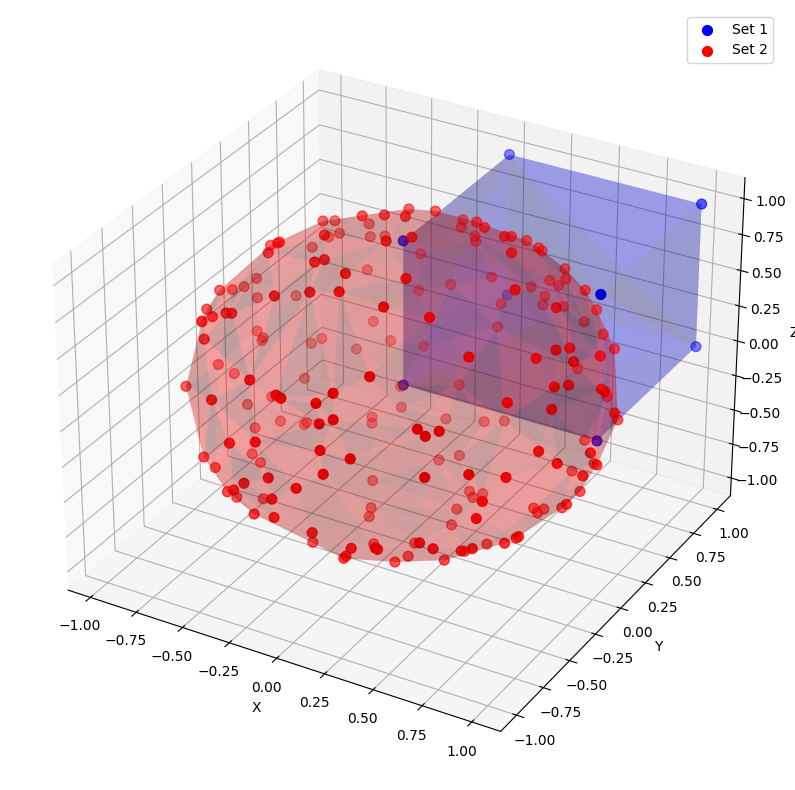

3D IoU (Convex Hulls): 0.0881


In [12]:
plot_hulls(points1, points_sphere)

iou = compute_3d_iou(points1, points_sphere)
print(f"3D IoU (Convex Hulls): {iou:.4f}")

#### **Estrategia Evolutiva EE($\mu + \lambda$)**

Las EE permiten una representación natural del problema. Su mecanismo de mutación ajusta automáticamente la exploración del espacio, mientras que la selección (μ + λ) preserva soluciones óptimas. Lo robusto de las EE las hace útiles para optimizar métricas complejas como el IoU 3D.

#### **Implementación**
Dado una población inicial de individuos:
- Se ordena la población inicial por el valor dado de fitness
- Por una cantidad $ G $ de generaciones:
    1. Se seleccionan los mejores $ \mu $ individuos.
    2. Por una cantidad $ \lambda $ de veces se hace el cruce, mutación y evaluación de individuos.
    3. Se junta la descendencia y los padres para generar una nueva población.
    4. Se ordena la población.
- Se devuelve el mejor individuo.

In [43]:
def EEmupluslambda(G, tau, eps0, x0, lambd, mu, box_min, box_max, target_shape,plot_interval):
    population = sorted(x0, key=lambda x: x[1], reverse=True)
    
    for generation in range(G):
        parents = population[:mu]
        
        offspring = []
        for _ in range(lambd):
            father1, father2 = random.sample(parents, 2)
            son = crossover(father1[0], father2[0])
            son_m = mutate(son, tau=tau, eps0=eps0, bbox_min=box_min, bbox_max=box_max)
            fitness = compute_3d_iou(son_m[0], target_shape)
            offspring.append((son_m, fitness))
        
        population = parents + offspring
        population = sorted(population, key=lambda x: x[1], reverse=True)[:mu]
                
        if plot_interval is not None:
            best_in_generation = max(population, key=lambda x: x[1])
            if generation % plot_interval == 0 or generation == G-1:
                print(f"Generation {generation}: Best IoU = {best_in_generation[1]:.4f}")
                plot_hulls(best_in_generation[0][0], target_shape)

    
    best_individual = max(population, key=lambda x: x[1])
    return best_individual

#### **Creación de Población inicial**
definimos el tamaño de la población inicial y la cantidad de puntos que vamos a manejar.

In [44]:
n_points = 100
m = 100
pob0 = [create_individual(-2, 2, n_points, points_sphere) for i in range(m)] 

## **Resultados**


Generation 0: Best IoU = 0.1104


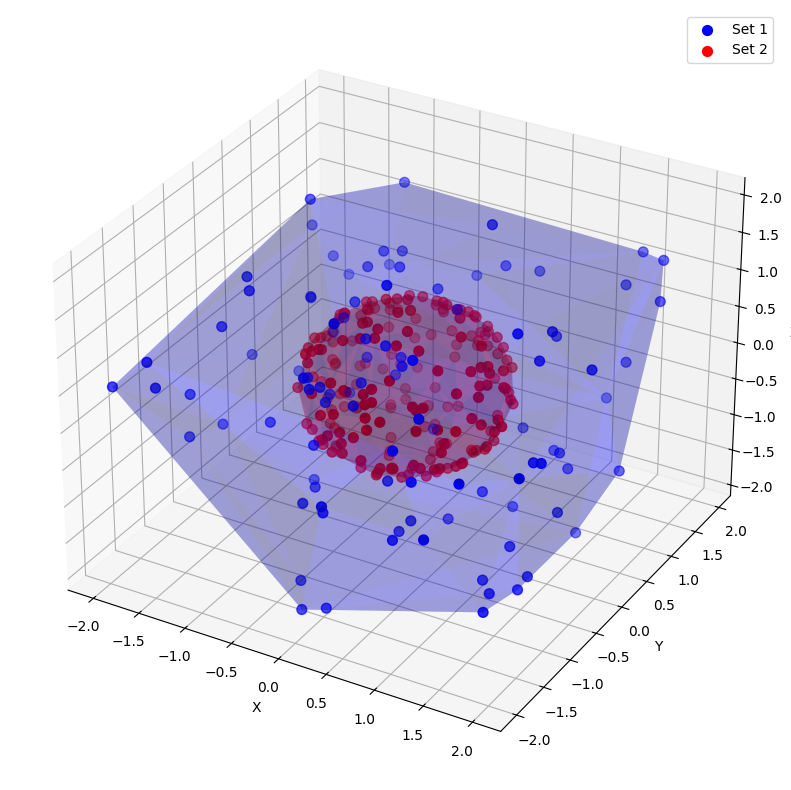

Generation 30: Best IoU = 0.2376


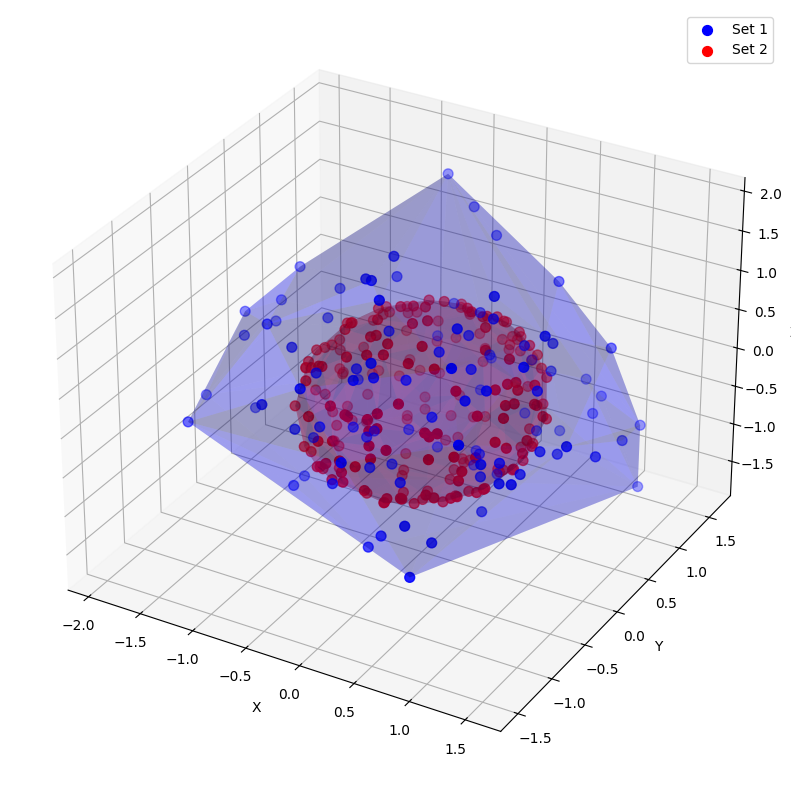

Generation 60: Best IoU = 0.5047


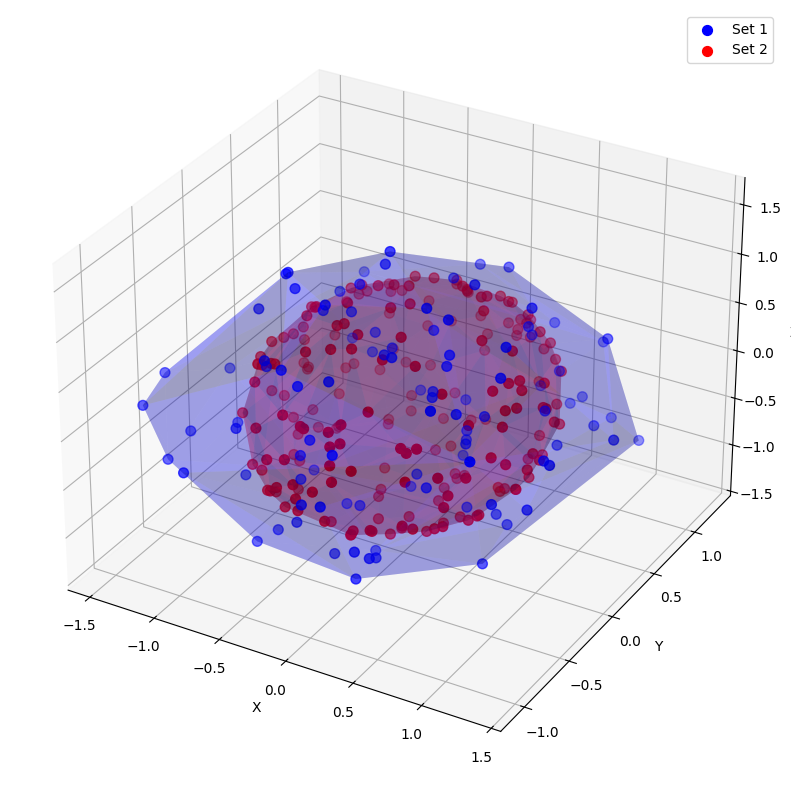

Generation 90: Best IoU = 0.7435


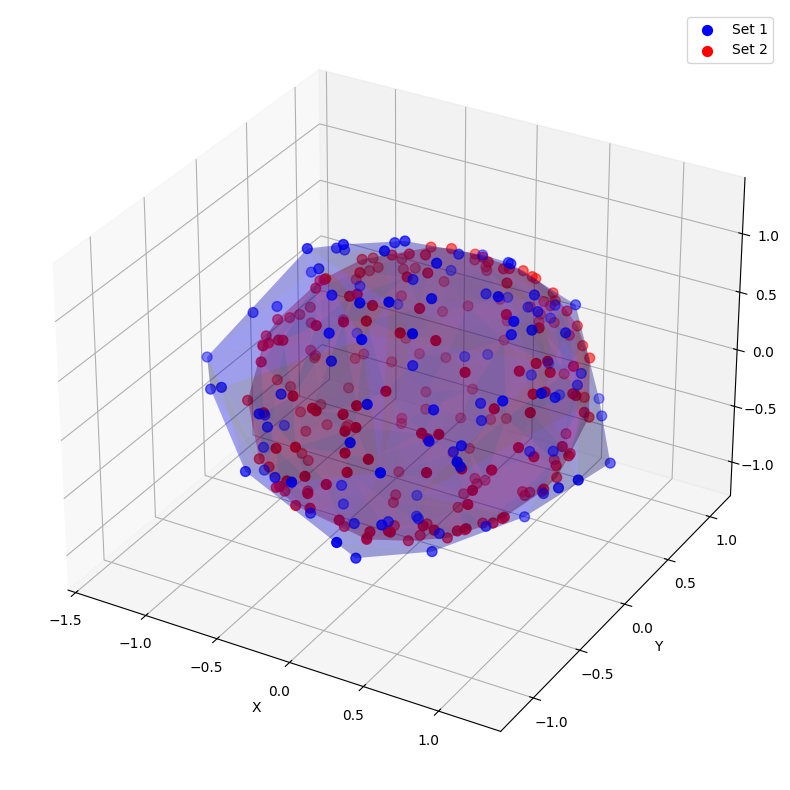

Generation 120: Best IoU = 0.8337


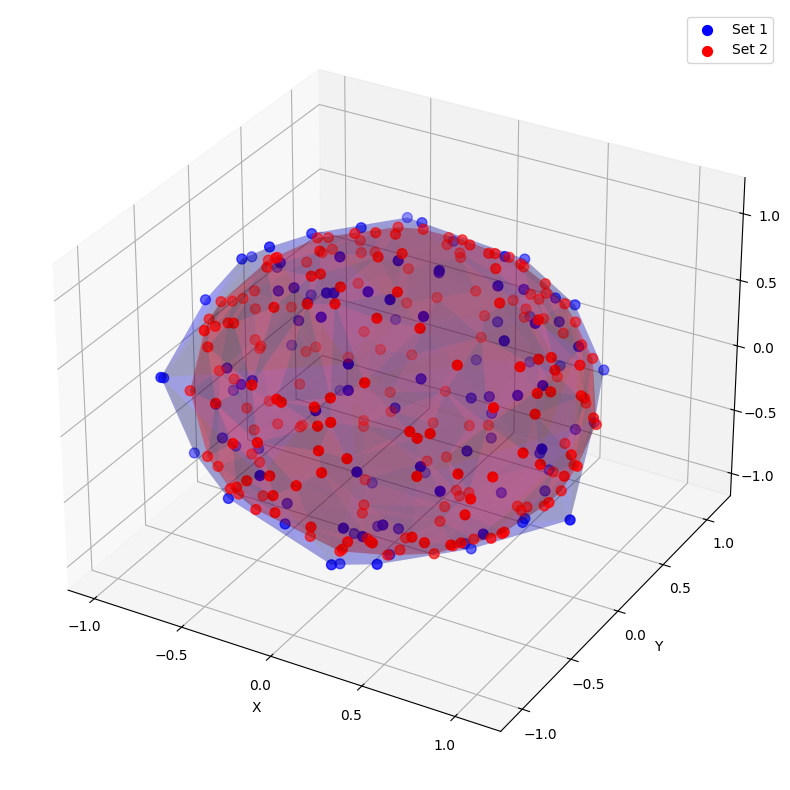

Generation 150: Best IoU = 0.8560


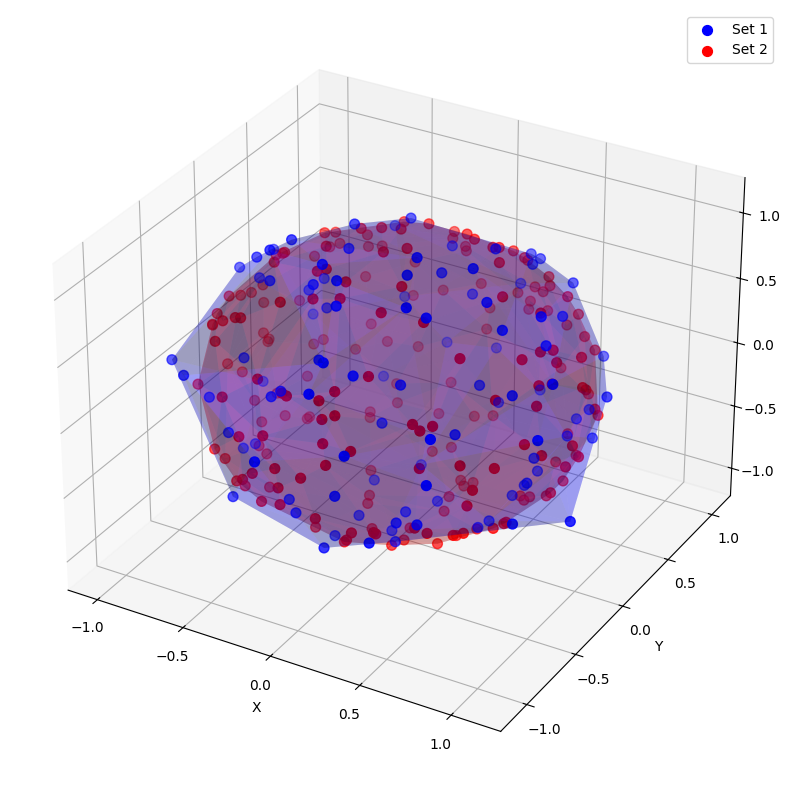

Generation 180: Best IoU = 0.8718


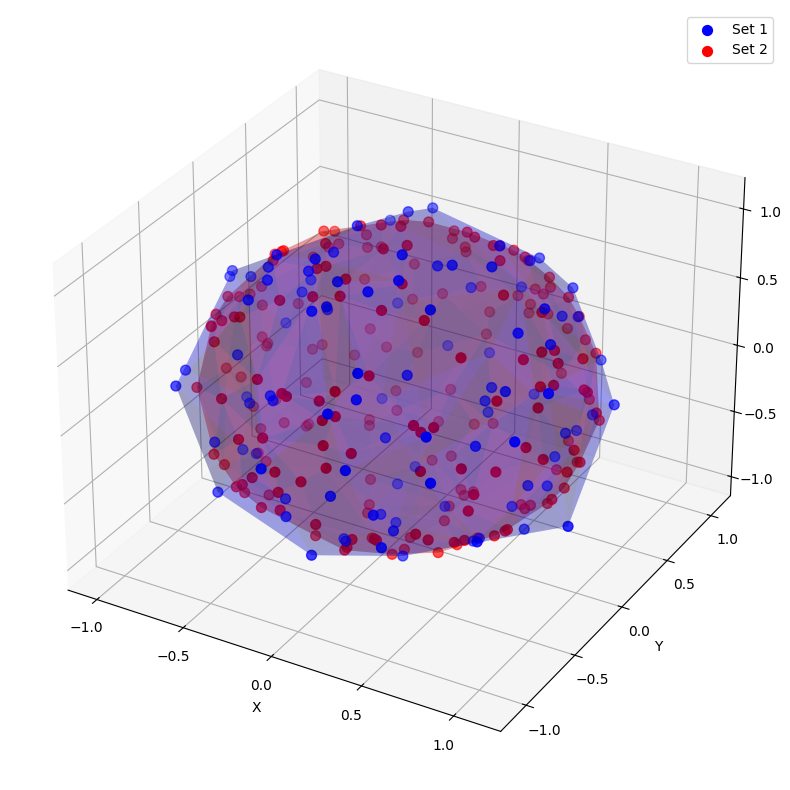

Generation 210: Best IoU = 0.8881


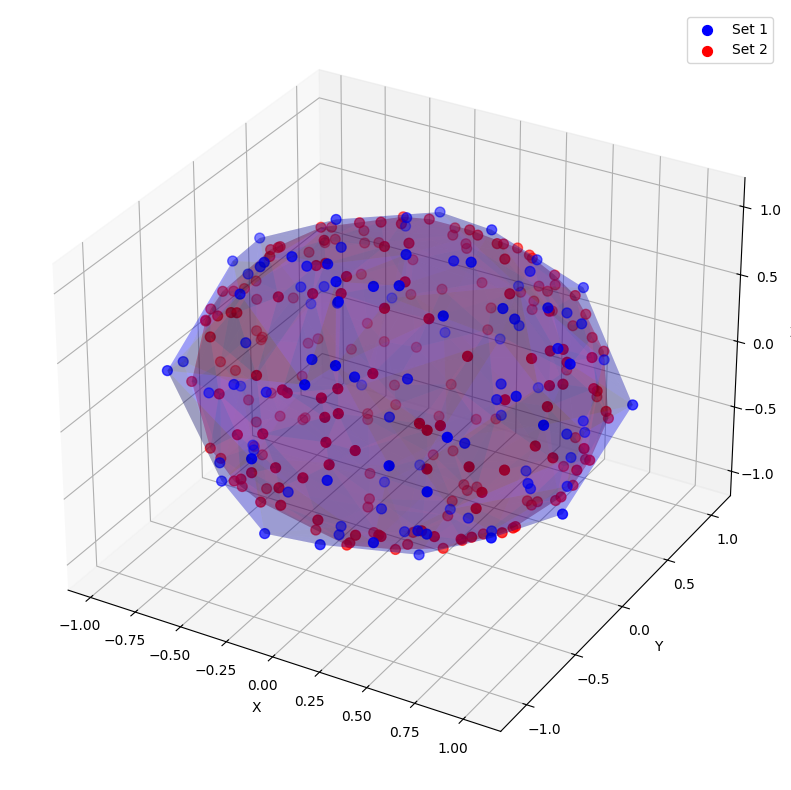

Generation 240: Best IoU = 0.9012


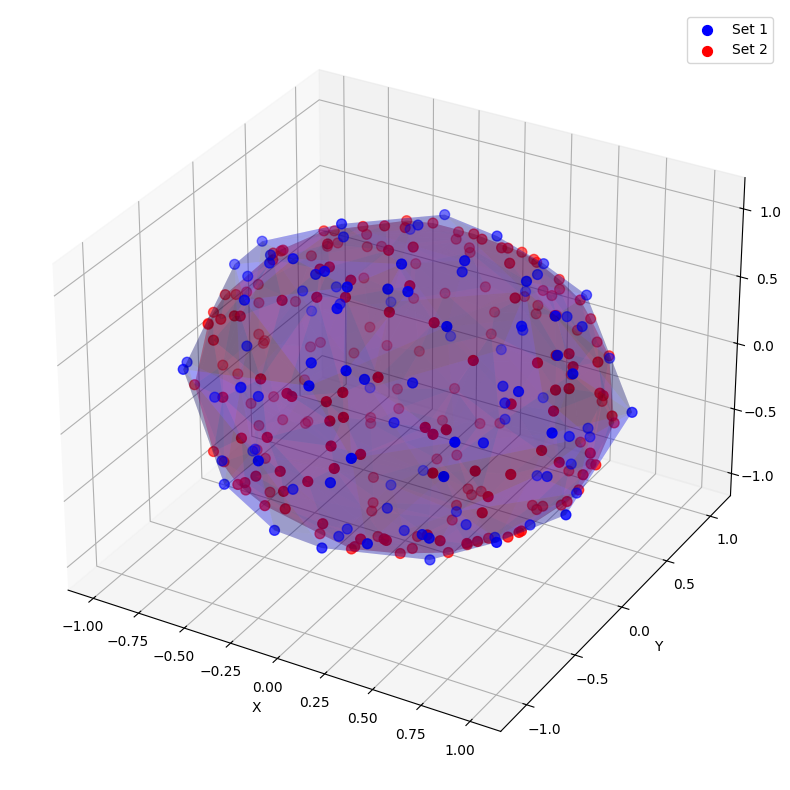

Generation 270: Best IoU = 0.9097


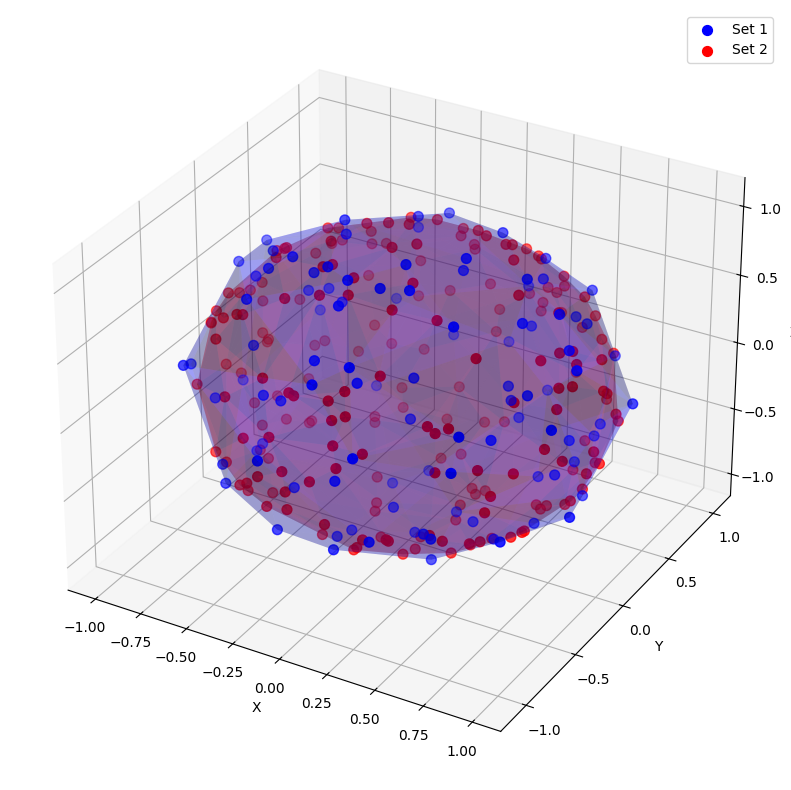

Generation 299: Best IoU = 0.9136


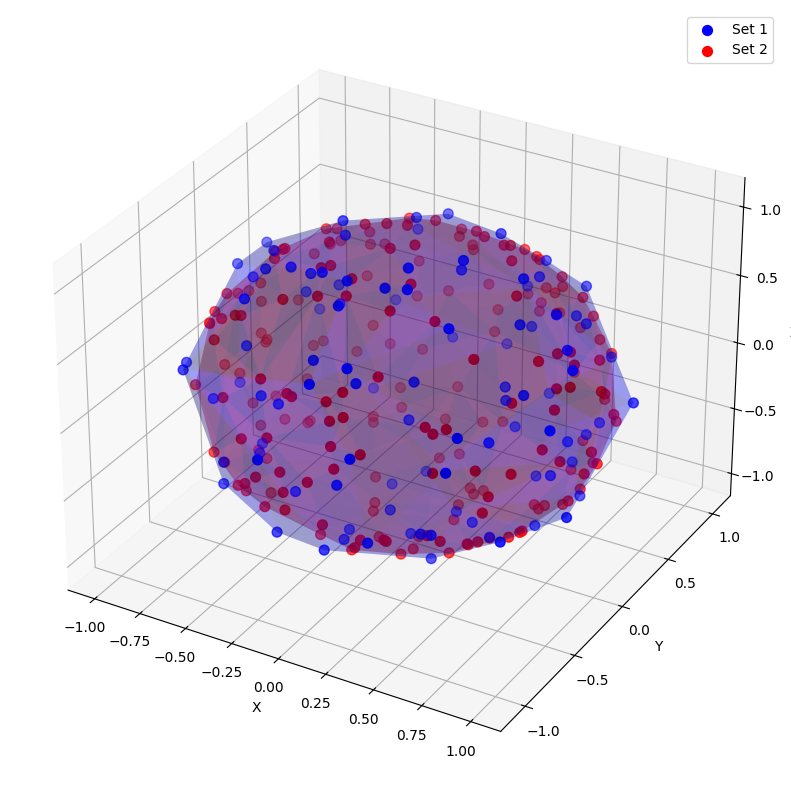

In [46]:
best =EEmupluslambda(
    G = 300,
    tau = 1/math.sqrt(n_points), 
    eps0 = 1e-5, 
    x0 = pob0, 
    lambd = m, 
    mu = 40,
    box_min = -2,
    box_max = 2,
    target_shape = points_sphere,
    plot_interval = 30 
)

In [47]:
best

((array([[ 0.7049337 ,  0.29197244, -0.32384058],
         [ 0.12362709, -0.79365707,  0.68633781],
         [ 0.1797311 , -0.26196636,  0.26872697],
         [-0.52735561, -0.46162448,  0.01569389],
         [ 0.07917476, -0.10578872, -1.00970038],
         [-0.72707113, -0.14784782, -0.7045966 ],
         [ 0.97477773, -0.25466652, -0.39957613],
         [ 1.00526044,  0.36561772,  0.03816559],
         [ 0.79540437, -0.57175669, -0.43474666],
         [ 0.904417  , -0.08023643,  0.52266578],
         [ 0.64224337,  0.59284505,  0.33146249],
         [-0.93956701, -0.45322287,  0.09382095],
         [-0.69386156,  0.2638254 ,  0.26307974],
         [ 0.27012197, -0.87467482, -0.45662755],
         [ 0.65085301,  0.45832324, -0.60995072],
         [ 0.23674029, -0.97531383,  0.20787812],
         [-0.74121314, -0.09790004, -0.67093535],
         [-0.1132213 , -0.44960635,  0.82181602],
         [ 0.29472364,  0.00232838,  1.02175529],
         [-0.02798136, -0.87325678,  0.56626045],


Después de una cantidad moderada de generaciones, lambda, mu y con la mitad de puntos,recordemos que la esfera está hecha a partir de 200 y nuestro individuo de 100 o menos dependiendo del número de puntos que conformen el Convex Hull. Se ha podido  aproximar la figura con un IoU de 0.91. Esto sugiere un buen individuo pero todavía con un poco de margen de mejora para alcanzar valores aún más cercanos a 1 (ya que teoricamente un 1.0 sería el la figura original).

Ahora observemos el comportamiento del EE con el número de puntos reducido dramáticamente.

Generation 0: Best IoU = 0.4165


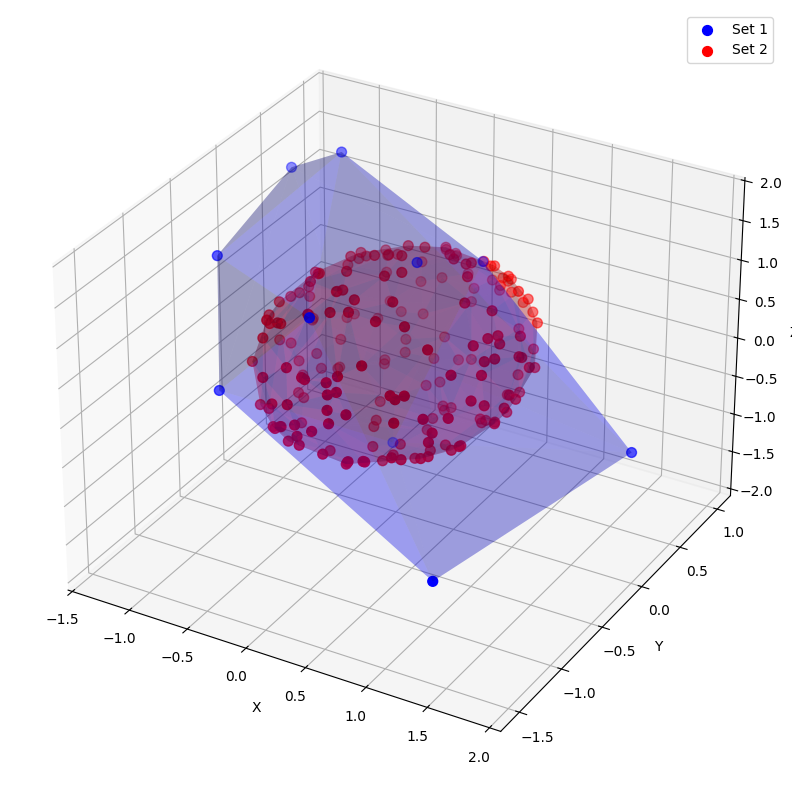

Generation 30: Best IoU = 0.7043


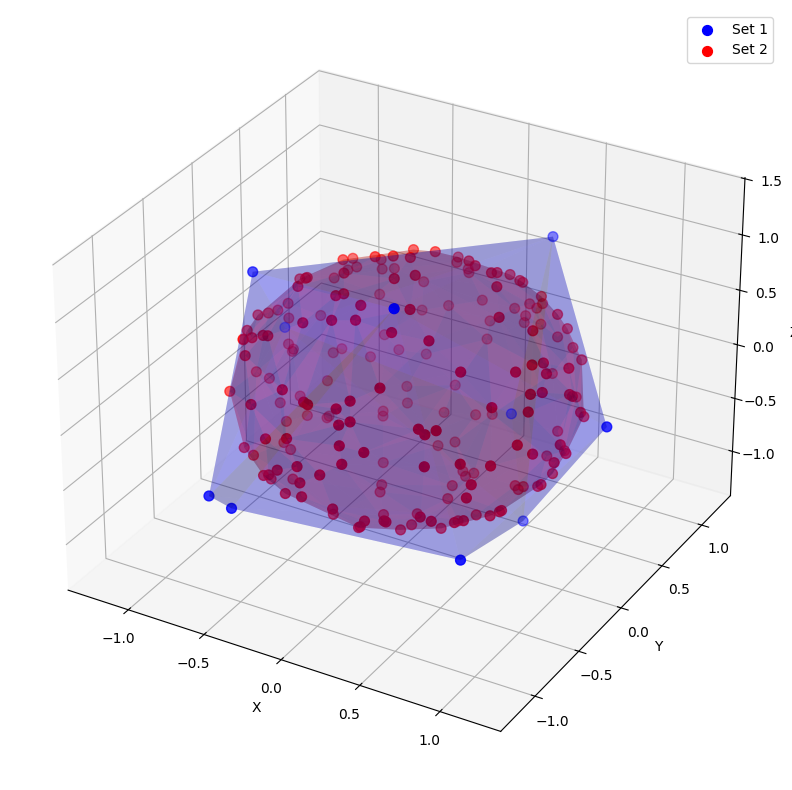

Generation 60: Best IoU = 0.7658


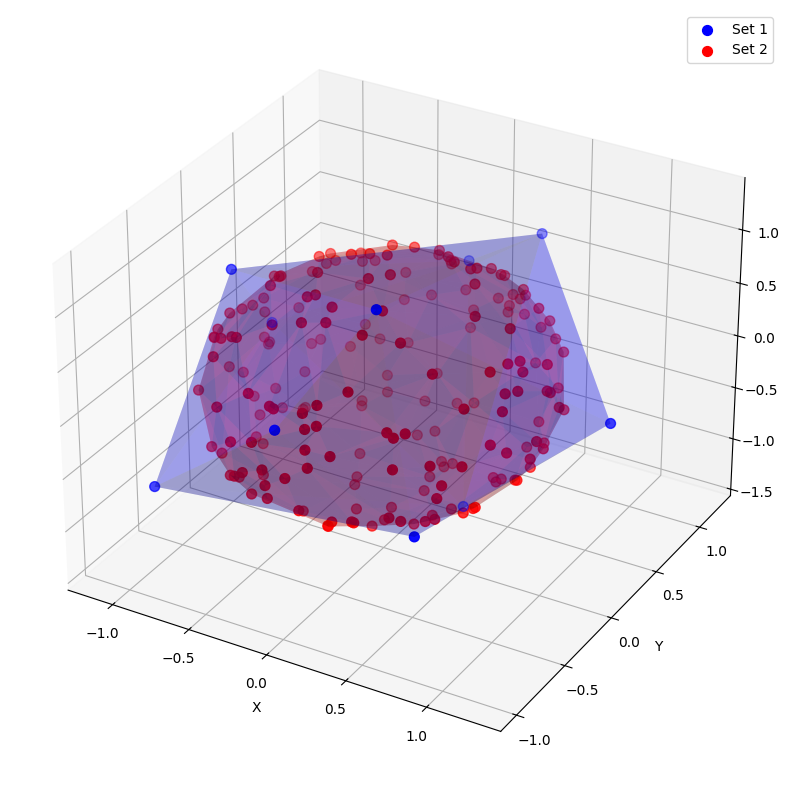

Generation 90: Best IoU = 0.7773


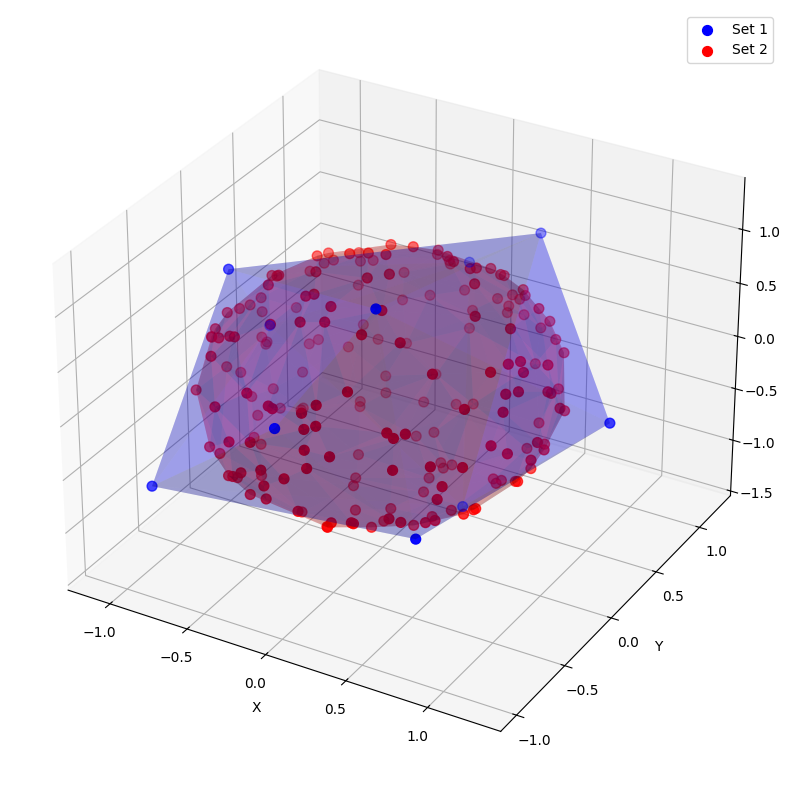

Generation 120: Best IoU = 0.7791


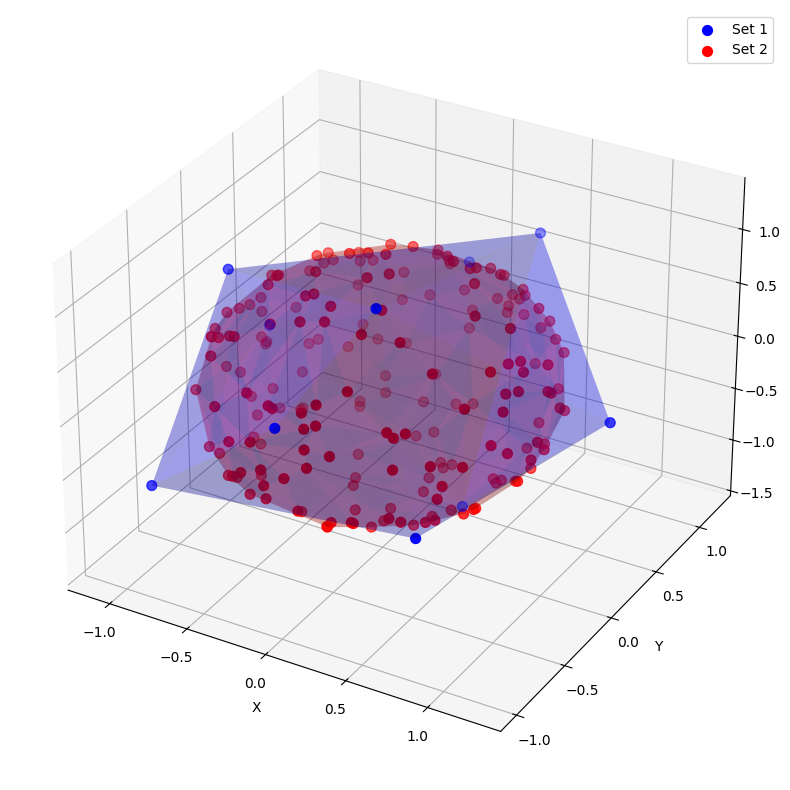

Generation 150: Best IoU = 0.7796


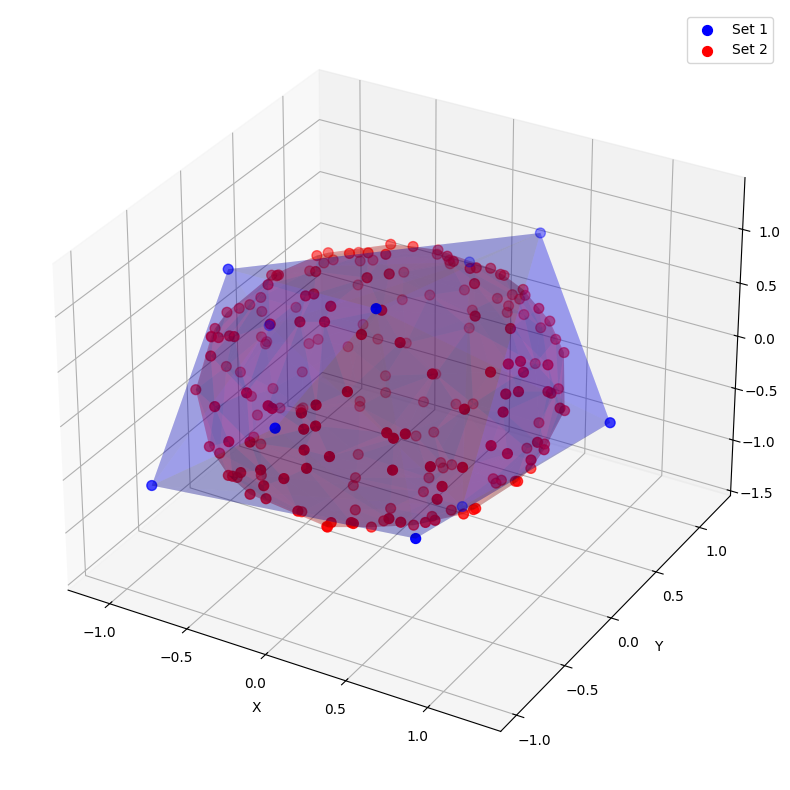

Generation 180: Best IoU = 0.7798


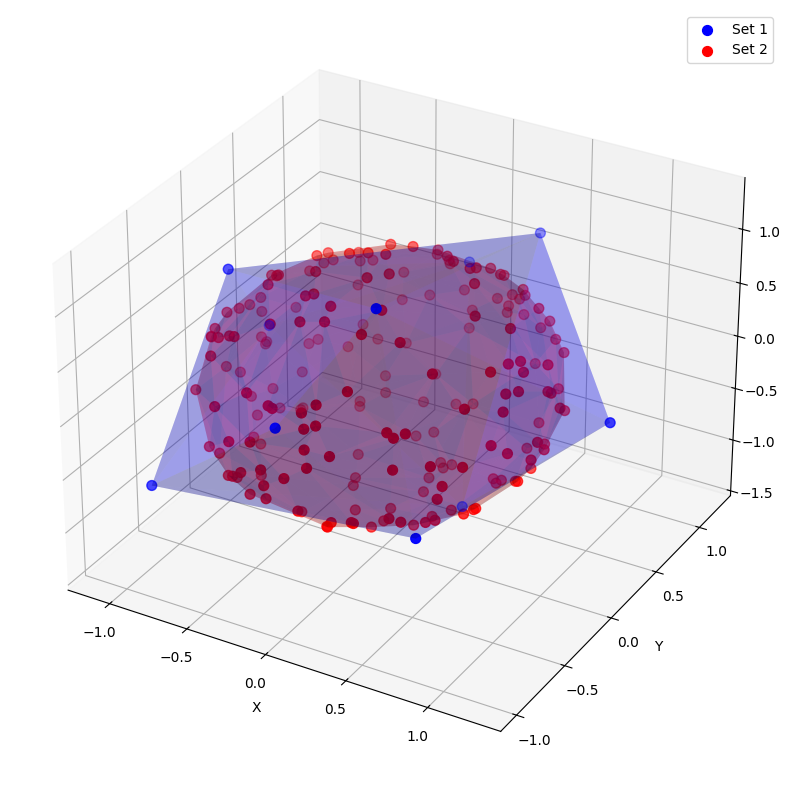

Generation 210: Best IoU = 0.7799


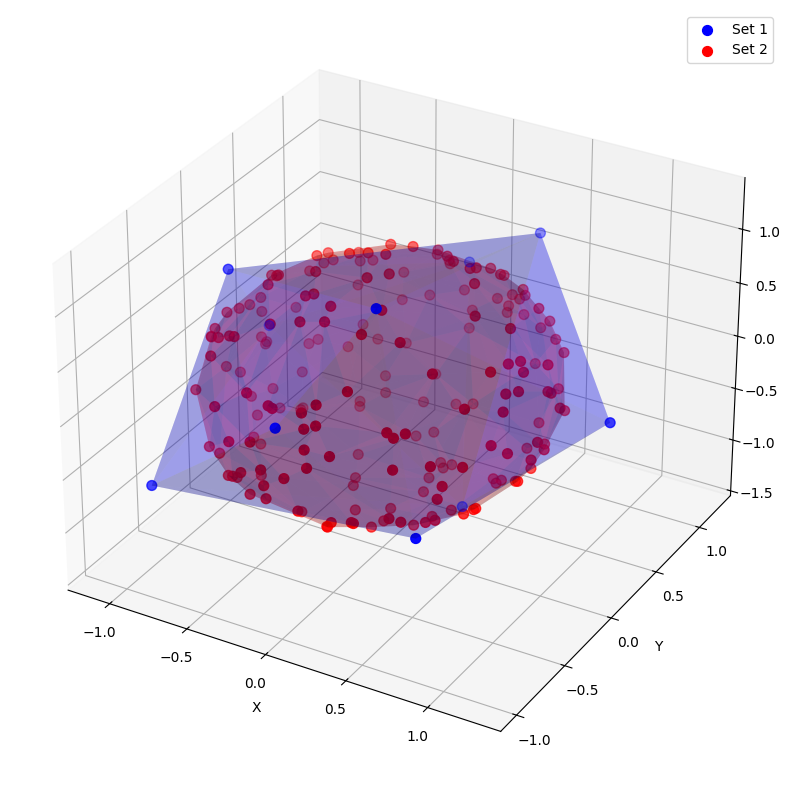

Generation 240: Best IoU = 0.7799


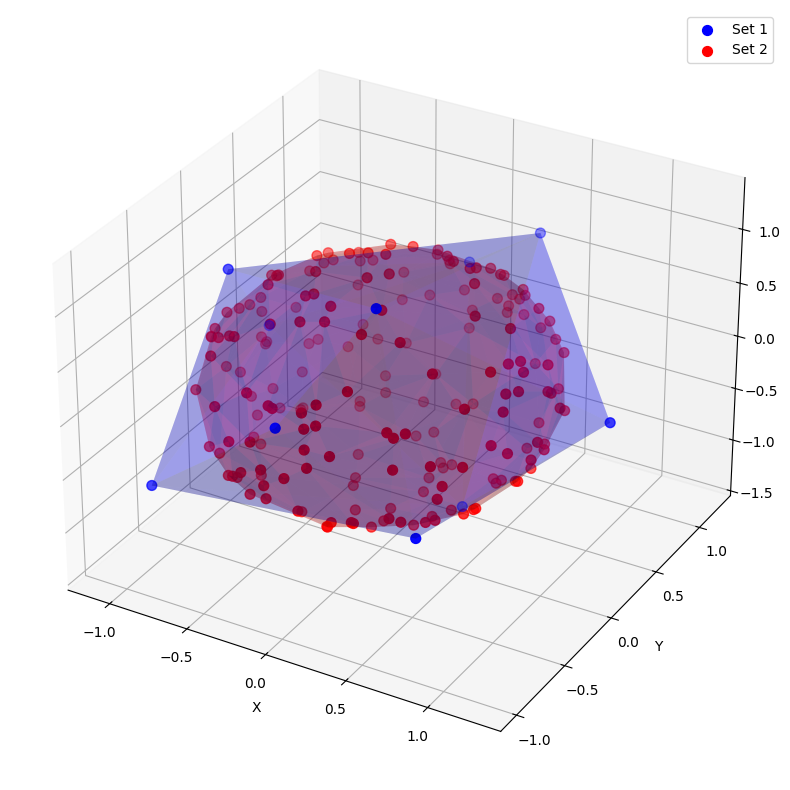

Generation 270: Best IoU = 0.7800


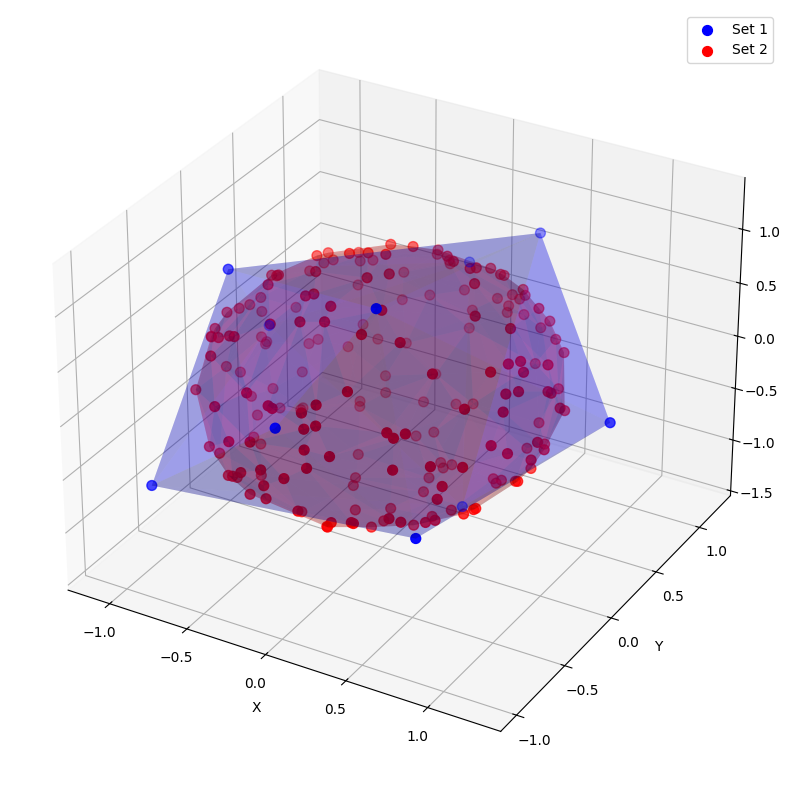

Generation 299: Best IoU = 0.7800


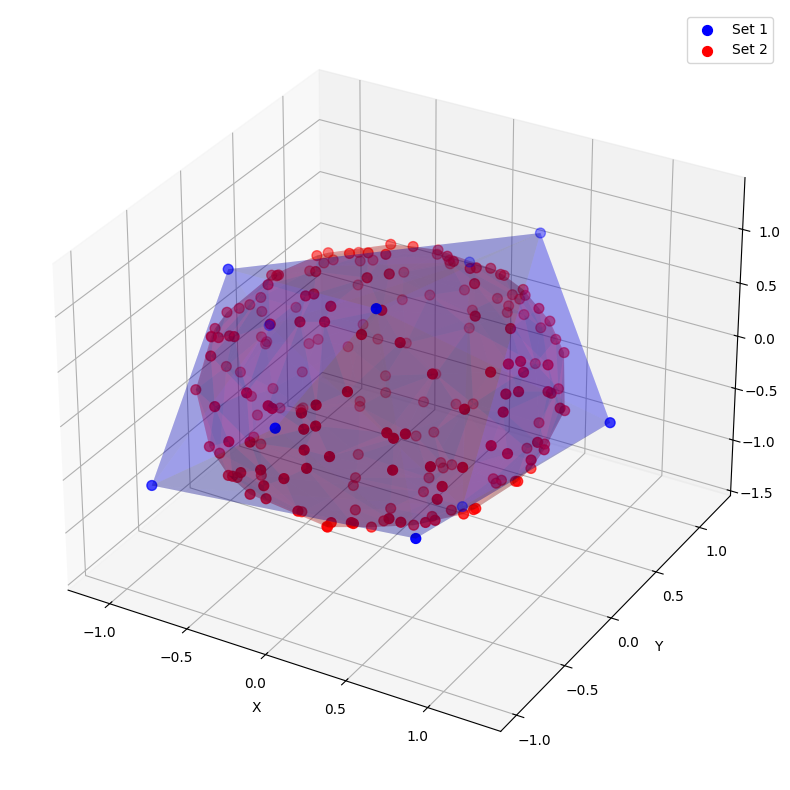

In [61]:
n_points_2 = 10
m_2 = 100
pob0_2 = [create_individual(-2, 2, n_points_2, points_sphere) for i in range(m_2)] 
best_2 =EEmupluslambda(
    G = 300,
    tau = 1/math.sqrt(n_points_2), 
    eps0 = 1e-5, 
    x0 = pob0_2, 
    lambd = m_2, 
    mu = 40,
    box_min = -2,
    box_max = 2,
    target_shape = points_sphere,
    plot_interval = 30 
)

In [62]:
best_2

((array([[-0.03353494, -0.98088004,  0.38646562],
         [-0.85674923, -0.17716662,  0.86238603],
         [-0.84024518, -0.96003766, -0.51918578],
         [ 1.26545833,  0.24509866,  0.00799472],
         [ 0.27583795,  0.38849976, -1.35474308],
         [-1.10056023,  0.5653916 , -0.33229878],
         [ 0.3238779 , -0.56885886,  1.28217504],
         [ 0.76172246, -0.89190951, -0.33310874],
         [ 0.27437793,  1.20809435,  0.62667664],
         [-0.17016646,  1.1940788 ,  0.18382856]]),
  1.3024935418273386e-05),
 0.7799895725584491)

Con este último experimento podemos observar que si el individuo no tiene suficientes puntos, el EE va a tener un límite menor a comparación de un individuo con más puntos, por lo que también hay tener en cuenta este parámetro a la hora que queramos aproximar otra figura.

### **Estadísticas**

Observemos las estadísticas de comportamiento del algoritmo

In [ ]:

from statistics import median

def Reporte():
    M = int(input('Número de ejecuciones (M): '))
    n_points = int(input('Número de puntos en cada individuo: '))
    m = int(input('Tamaño de población inicial: '))
    lambda_ =  int(input('Tamaño de lambda: '))
    mu = int(input('Número de padres (mu): '))
    G = int(input('Número de generaciones (G): '))
    
    tau = 1/math.sqrt(n_points)
    eps0 = 1e-5
    box_min, box_max = -2, 2
    
    results = []
    
    for _ in range(M):
        pob0 = [create_individual(box_min, box_max, n_points, points_sphere) for _ in range(m)]
        
        best = EEmupluslambda(
            G=G,
            tau=tau,
            eps0=eps0,
            x0=pob0,
            lambd=lambda_,
            mu=mu,
            box_min=box_min,
            box_max=box_max,
            target_shape=points_sphere,
            plot_interval=None
            
        )
        
        results.append((best[0], best[1]))
    
    results.sort(key=lambda x: x[1], reverse=True) 
    best_ind, best_fitness = results[0]
    worst_ind, worst_fitness = results[-1]
    median_fitness = median([x[1] for x in results])
    avg_fitness = np.mean([x[1] for x in results])
    std_fitness = np.std([x[1] for x in results])
    
    print('-'*70)
    print(f'REPORTE DE {M} EJECUCIONES')
    print('-'*70)
    print(f'Parámetros:')
    print(f'- Puntos por individuo (n_points): {n_points}')
    print(f'- Tamaño población inicial (m): {m}')
    print(f'- Tamaño de lambda: {lambda_}')
    print(f'- Padres seleccionados (mu): {mu}')
    print(f'- Generaciones (G): {G}')
    print(f'- τ: {tau:.4f}, ε₀: {eps0}')
    print(f'- Rango de búsqueda: [{box_min}, {box_max}]')
    print('-'*70)
    print(f"Mejor solución (IoU = {best_fitness:.4f})")
    print('-'*70)
    print(f"Peor solución (IoU = {worst_fitness:.4f})")
    print('-'*70)
    print(f"Mediana de IoU: {median_fitness:.4f}")
    print('-'*70)
    print(f"IoU promedio: {avg_fitness:.4f}")
    print('-'*70)
    print(f"Desviación estándar de IoU: {std_fitness:.4f}")
    print('-'*70)
    
    return {
        'best_solution': best_ind,
        'best_fitness': best_fitness,
        'worst_fitness': worst_fitness,
        'median_fitness': median_fitness,
        'avg_fitness': avg_fitness,
        'std_fitness': std_fitness,
        'all_results': results
    }

In [56]:
datos = Reporte()

----------------------------------------------------------------------
REPORTE DE 10 EJECUCIONES DEL ALGORITMO EVOLUTIVO
----------------------------------------------------------------------
Parámetros:
- Puntos por individuo (n_points): 100
- Tamaño población inicial (m): 100
- Tamaño de lambda: 100
- Padres seleccionados (mu): 40
- Generaciones (G): 100
- τ: 0.1000, ε₀: 1e-05
- Rango de búsqueda: [-2, 2]
----------------------------------------------------------------------
Mejor solución (IoU = 0.7948)
----------------------------------------------------------------------
Peor solución (IoU = 0.6700)
----------------------------------------------------------------------
Mediana de IoU: 0.7549
----------------------------------------------------------------------
IoU promedio: 0.7444
----------------------------------------------------------------------
Desviación estándar de IoU: 0.0369
----------------------------------------------------------------------


Para esta aproximación podemos observar que se encuentra en un rango algo cercano, la diferencia promedio entre soluciones bajaría entre más generaciones tenga el algoritmo y llegaría a un tope eventualmente, pero el tiempo de ejecución también sería mucho mayor.

Para evaluación y futura consideración de la EE haremos un análisis de los parámetros en base al IoU (para desempeño) y el tiempo (costo computacional).

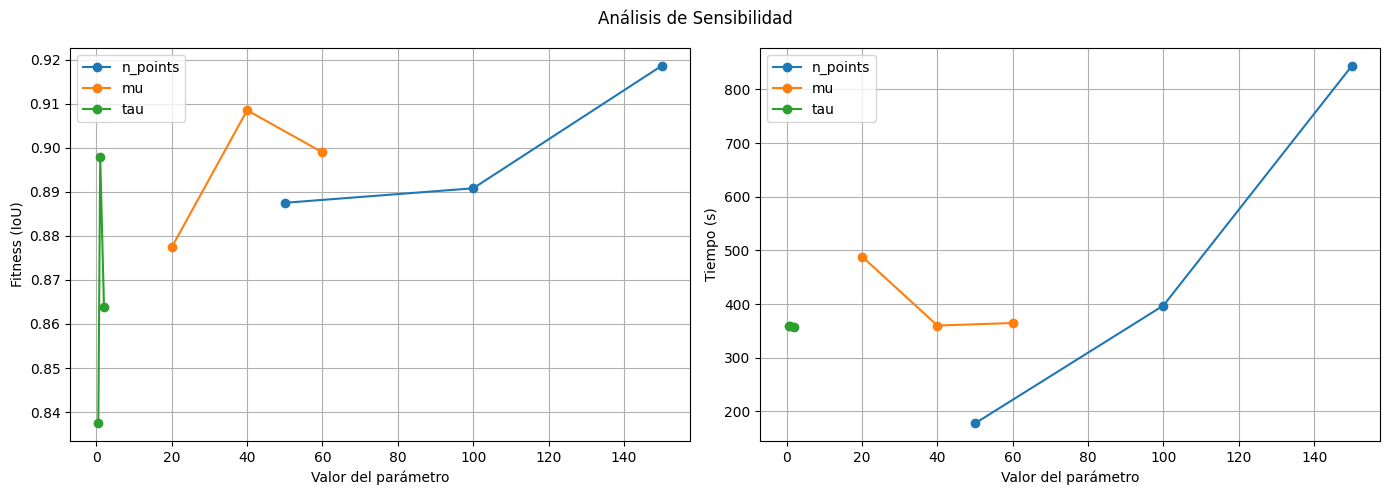

In [ ]:
def sensitivity_analysis():
    base_params = {
        'G': 200,
        'tau': None,
        'eps0': 1e-5,
        'box_min': -2,
        'box_max': 2,
        'plot_interval': None
    }

    n_points_values = [50, 100, 150]
    mu_values = [20, 40, 60]
    tau_factors = [0.5, 1.0, 2.0]

    results = []

    for n_points in n_points_values:
        target_sphere =points_sphere
        m = 2 * n_points  
        
        pob0 = [create_individual(-2, 2, n_points, target_sphere) for _ in range(m)]
        
        params = base_params.copy()
        params['tau'] = 1/math.sqrt(n_points)
        
        start_time = time.time()
        best = EEmupluslambda(
            G=params['G'],
            tau=params['tau'],
            eps0=params['eps0'],
            x0=pob0,
            lambd=m,
            mu=40,  # Valor fijo
            box_min=params['box_min'],
            box_max=params['box_max'],
            target_shape=target_sphere,
            plot_interval=params['plot_interval']
        )
        elapsed = time.time() - start_time
        
        results.append({
            'param': 'n_points',
            'value': n_points,
            'fitness': best[1],
            'time': elapsed
        })

    n_points = 100
    target_sphere = points_sphere
    m = 2 * n_points
    
    for mu in mu_values:
        pob0 = [create_individual(-2, 2, n_points, target_sphere) for _ in range(m)]
        
        params = base_params.copy()
        params['tau'] = 1/math.sqrt(n_points)
        
        start_time = time.time()
        best = EEmupluslambda(
            G=params['G'],
            tau=params['tau'],
            eps0=params['eps0'],
            x0=pob0,
            lambd=m,
            mu=mu,
            box_min=params['box_min'],
            box_max=params['box_max'],
            target_shape=target_sphere,
            plot_interval=params['plot_interval']
        )
        elapsed = time.time() - start_time
        
        results.append({
            'param': 'mu',
            'value': mu,
            'fitness': best[1],
            'time': elapsed
        })

    for factor in tau_factors:
        pob0 = [create_individual(-2, 2, n_points, target_sphere) for _ in range(m)]
        
        params = base_params.copy()
        params['tau'] = factor/math.sqrt(n_points)
        
        start_time = time.time()
        best = EEmupluslambda(
            G=params['G'],
            tau=params['tau'],
            eps0=params['eps0'],
            x0=pob0,
            lambd=m,
            mu=40,  
            box_min=params['box_min'],
            box_max=params['box_max'],
            target_shape=target_sphere,
            plot_interval=params['plot_interval']
        )
        elapsed = time.time() - start_time
        
        results.append({
            'param': 'tau',
            'value': factor,
            'fitness': best[1],
            'time': elapsed
        })

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    for param in ['n_points', 'mu', 'tau']:
        param_data = [r for r in results if r['param'] == param]
        ax1.plot([d['value'] for d in param_data], 
                [d['fitness'] for d in param_data],
                'o-', label=param)
    ax1.set_xlabel('Valor del parámetro')
    ax1.set_ylabel('Fitness (IoU)')
    ax1.legend()
    ax1.grid(True)
    
    for param in ['n_points', 'mu', 'tau']:
        param_data = [r for r in results if r['param'] == param]
        ax2.plot([d['value'] for d in param_data], 
                [d['time'] for d in param_data],
                'o-', label=param)
    ax2.set_xlabel('Valor del parámetro')
    ax2.set_ylabel('Tiempo (s)')
    ax2.legend()
    ax2.grid(True)
    
    plt.suptitle('Análisis de Sensibilidad')
    plt.tight_layout()
    plt.show()

    return results

sensitivity_results = sensitivity_analysis()

Podemos observar que para el desempeño de IoU es n_points es el parámetro más importante, pero mu también tiene un gran papel especialmente en mu = 40, mientras que el valor de 1.0 de tau es especialmente bueno.

Para el tiempo n_points vuelve a ser el valor de mayor influencia, mientras mu y tau no tienen mayor importancia aquí.

## **Conclusiones**

La metaheurística basada en estrategias evolutivas (𝜇+𝜆) ha demostrado ser efectiva para la aproximación de figuras tridimensionales, utilizando la envolvente convexa de un conjunto de puntos como representación geométrica. Esta estrategia permite encontrar soluciones razonablemente precisas con una cantidad de información reducida, cumpliendo con el objetivo de compresión y simplificación de formas 3D.

Sin embargo, debido a la propia naturaleza de las técnicas utilizadas (particularmente el uso de envolventes convexas), es esperable que el algoritmo enfrente limitaciones al aproximar figuras más complejas, especialmente aquellas con concavidades pronunciadas, cavidades internas o geometrías no convexas. En estos escenarios, una sola envolvente convexa difícilmente puede capturar todos los detalles estructurales de la figura objetivo sin perder fidelidad.

Una posible línea de mejora ante esta situación es el preprocesamiento por segmentación, es decir, dividir figuras complejas en subregiones más simples (idealmente convexas), de forma que el algoritmo evolutivo pueda aproximar cada subfigura individualmente. Posteriormente, la combinación de estas soluciones locales podría generar una aproximación global más precisa y flexible, incluso para estructuras con geometrías no triviales. Esta estrategia modular permitiría extender el alcance del enfoque actual a una gama más amplia de aplicaciones.

Por otro lado, se ha identificado que el tiempo de ejecución del algoritmo puede ser elevado, especialmente al aumentar la cantidad de puntos o el número de generaciones. Esto representa una barrera práctica, particularmente si se desea utilizar el algoritmo en contextos interactivos o de tiempo real. Por lo tanto, la optimización del rendimiento computacional es otra vía de mejora. Algunas estrategias posibles incluyen: paralelización del algoritmo (por ejemplo, mediante procesamiento distribuido o GPU), diseño de operadores evolutivos más eficientes, o incorporación de mecanismos de terminación temprana en función de la tasa de mejora.

## **Dependencias**

- Scipy ConvexHull: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html

- Scipy Delunay: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Delaunay.html

- Numpy: https://numpy.org/

- Math: https://docs.python.org/3/library/math.html